# Grover Search

In [1]:
import math
import random

from qiskit import QuantumCircuit, QuantumRegister, execute, Aer
from qiskit.visualization import plot_histogram
from IPython.display import display

simulator = Aer.get_backend("qasm_simulator")

## Define the oracle in terms of a phase shift of the input register

For simplicity sake within the Qiskit environment, I have chosen to implement the oracle for this problem according to:

Figgatt, C., Maslov, D., Landsman, K.A. et al. [Complete 3-Qubit Grover search on a programmable quantum computer](https://www.nature.com/articles/s41467-017-01904-7)r. Nat Commun 8, 1918 (2017)

The oracle shifts the phase of the final qubit in the input register when the $n$-qubit system is in state $|a\rangle$. This eliminates the need for an additional output qubit for the oracle. There are also $n-2$ ancillary qubits needed to do the multi-controlled $Z$ gates in the oracle and diffusion operator. This is due to the fact that Qiskit is meant to run on actual quatum hardware and as such requires physically realizable gates. 

In [2]:
def basic_oracle(circ, q_controls, q_ancillae, a):
    """ Phase shifts the last qubit of the input register if the qubits are in state a """
    int_bits = format(a,'b').zfill(len(q_controls))
    low_bits = [i for i, c in enumerate(int_bits) if c == '0']
    
    # Oracle operator
    if len(low_bits) > 0:
        circ.x(low_bits)
    circ.mcmt(q_controls[:-1], q_ancillae, QuantumCircuit.cz, q_controls[-1:])
    if len(low_bits) > 0:
        circ.x(low_bits)

def simple_3sat_oracle(circ, q_control, q_ancillae, q_targets, table_3sat):
    """ Solves the given n-variable 3SAT(CNF) problem """
    num_vars = len(table_3sat[0])
    num_rows = len(table_3sat)
    assert (num_ancillary >= (2*num_rows)), f"{num_rows} clause 3SAT requires {2*num_rows} ancillary qubits but only {num_ancillary} available"
    
    # 3SAT Oracle operator
    # Translate the 3SAT clauses into quantum gates using De Morgan's Law
    for j, row in enumerate(table_3sat):
        qubits_to_negate = [k for k, var in enumerate(row) if  var == 'T']
        if len(qubits_to_negate) > 0:
            circuit.x(qubits_to_negate)
        circuit.mct(q_controls, q_ancillae[i], None, mode="advanced")
        if len(qubits_to_negate) > 0:
            circuit.x(qubits_to_negate)
        circuit.barrier()
    
    # AND all of the clauses
    circuit.x(q_ancillae[:num_rows])
    circuit.h(q_targets[0])
    circuit.mct(q_ancillae[:num_rows], q_targets[0], q_ancillae[num_rows:], mode="advanced")
    circuit.h(q_targets[0])
    circuit.x(q_ancillae[:num_rows])
    circuit.barrier()
    
    # Uncompute the clauses
    for j, row in enumerate(table_3sat[::-1]):
        qubits_to_negate = [k for k, var in enumerate(row) if  var == 'T']
        if len(qubits_to_negate) > 0:
            circuit.x(qubits_to_negate)
        circuit.mct(q_controls, q_ancillae[i], None, mode="advanced")
        if len(qubits_to_negate) > 0:
            circuit.x(qubits_to_negate)
        circuit.barrier()
    
    
def diffusion_op(circ, q_controls, q_ancillae, q_target=None):
    """ Boosts the amplitude of state marked by oracle while surpressing the rest """
    if q_target is None:
        # Diffusion operator without ancillary target qubit
        circ.h(q_controls)
        circ.x(q_controls)
        circ.barrier()
        circ.mcmt(q_controls[:-1], q_ancillae, QuantumCircuit.cz, q_controls[-1:])
        circ.barrier()
        circ.x(q_controls)
        circ.h(q_controls)
    
    else:
        # Diffusion operator using ancillary target qubit
        circ.h(q_controls)
        circ.x(q_controls)
        circ.barrier()
        circ.mct(q_controls, q_target, None, mode="advanced")
        circ.barrier()
        circ.x(q_controls)
        circ.h(q_controls)
    
    
def parse_3sat_to_table(input_3sat):
    """ Parses 3SAT problems of form (~x0|~x1|~x2) & (x0|~x1|x2) & ... & (x0|~x1|~x2) to array """
    parsed_3sat = [[var.strip("( )") for var in row.strip().split('|')] for row in input_3sat.split('&') ]
    var2col = {v[-2:]: int(v[-1]) for row in parsed_3sat for v in row}
    table_3sat = [[None]*len(var2col) for i in range(len(parsed_3sat))]

    for i, row in enumerate(parsed_3sat):
        for var in row:
            table_3sat[i][var2col[var[-2:]]] = 'F' if var[0] == '~' else 'T'
    return table_3sat

## Grover's algorithm to search for index in database

Set value of $a$ and number of qubits accordingly. Drawing the circuit is recommended only for small ($n < 5$) circuits.

Searching for 15 on 4-qubit system...
Performing 0th Grover iteration.
Performing 1th Grover iteration.
Performing 2th Grover iteration.
Grover search found index: 15 with probability 0.9650


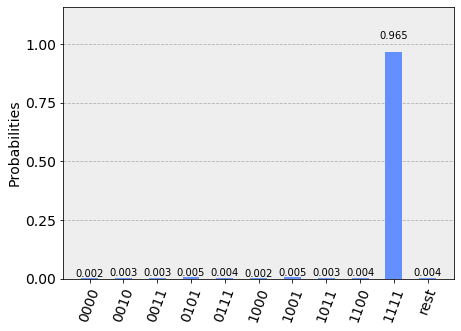

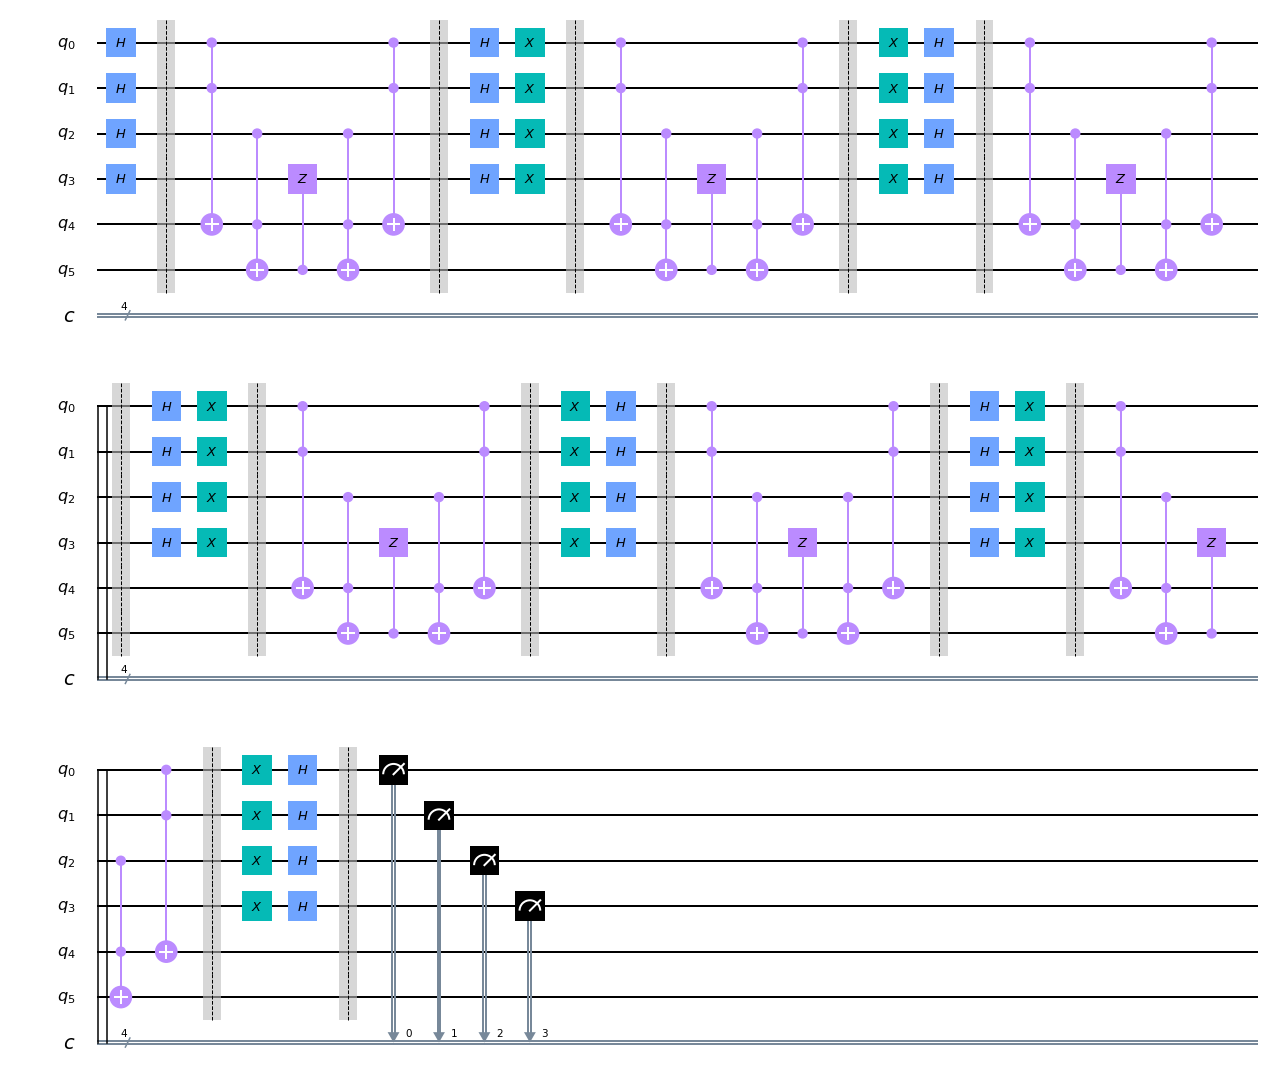

In [3]:
# Set up a circuit to search the length N database
num_qubits = random.randint(2, 8)  # input register
num_ancillary = max(0, num_qubits - 2)  # used for multicontrol gates
num_bits = num_qubits  # classical bits to read our answer out to
N = 2**num_qubits

a = random.randint(0, N-1)  # The index for which the oracle is conditioned on
assert a < N, f"Value a must be less than N: a={a} > {N}=N"
print(f"Searching for {a} on {num_qubits}-qubit system...")

# Optimal number iterations per An Introduction to Quantum Computing  by Kaye, Laflamme and Mosca 
num_iters = math.floor(math.pi/4 * math.sqrt(N))  

circuit = QuantumCircuit(num_qubits + num_ancillary, num_bits)
q_controls = [circuit.qubits[i] for i in range(num_qubits)]
q_ancillae = [circuit.qubits[i] for i in range(num_qubits, num_qubits+num_ancillary)]

# Initialize the input register with N-fold Hadamard tensor product 
circuit.h(range(num_qubits))
circuit.barrier()  # simply to make the circuit drawing look better
for i in range(num_iters):
    print(f"Performing {i}th Grover iteration.")
    basic_oracle(circuit, q_controls, q_ancillae, a)
    circuit.barrier()
    diffusion_op(circuit, q_controls, q_ancillae)
    circuit.barrier()

circuit.measure(range(num_qubits), range(num_bits))

# Execute the job with 1000 shots and analyze the results
shots = 1000
job = execute(circuit, simulator, shots=shots)
result = job.result()
counts = result.get_counts()
found_bits = max(counts, key=lambda x: counts[x])
found_int = int(found_bits[::-1], 2)  # Qiskit is little endian

print(f"Grover search found index: {found_int} with probability {counts[found_bits]/shots:0.4f}")
display(plot_histogram(counts, number_to_keep=10))
if num_qubits < 5:
    display(circuit.draw())

## Grover's search to solve a 3 variable 3SAT problem

Implementing oracle from example [here](https://community.qiskit.org/textbook/ch-applications/satisfiability-grover.html).

3SAT predicate: `(~x0|~x1|~x2) & (x0|~x1|x2) & (x0|x1|~x2) & (x0|~x1|~x2) & (~x0|x1|x2)`

The table format of the problem allows us to translate it directly into gates:

    0 1 2
    -----
    F F F
    T F T
    T T F
    T F F
    F T T

Performing 0th Grover iteration.
Performing 1th Grover iteration.


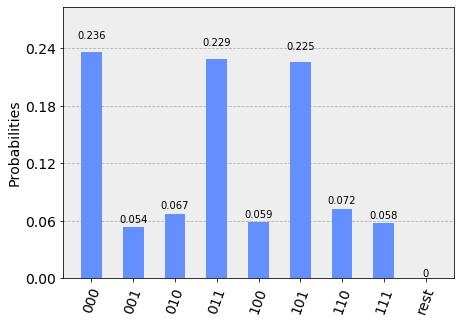

In [4]:
input_3sat = "(~x0|~x1|~x2) & (x0|~x1|x2) & (x0|x1|~x2) & (x0|~x1|~x2) & (~x0|x1|x2)"
table_3sat = parse_3sat_to_table(input_3sat)
num_vars = len(table_3sat[0])
num_rows = len(table_3sat)

num_qubits = num_vars + 1 # input register
num_ancillary = 2 * num_rows # used for multicontrol gates
num_bits = num_vars  # classical bits to read our answer out to
N = 2**(num_qubits-1)

# Optimal number iterations per An Introduction to Quantum Computing  by Kaye, Laflamme and Mosca 
num_iters = math.floor(math.pi/4 * math.sqrt(N))  

circuit = QuantumCircuit(num_qubits + num_ancillary, num_bits)
q_ancillae = [circuit.qubits[i] for i in range(num_qubits, num_qubits+num_ancillary)]
q_controls = [circuit.qubits[i] for i in range(num_qubits-1)]
q_targets = [circuit.qubits[num_qubits-1]]

# Initialize the input register with N-fold Hadamard tensor product 
circuit.x(num_qubits-1)
circuit.h(range(num_qubits))

# Grover iteration
for i in range(num_iters):
    print(f"Performing {i}th Grover iteration.")
    simple_3sat_oracle(circuit, q_controls, q_ancillae, q_targets, table_3sat)
    diffusion_op(circuit, q_controls, q_ancillae, q_targets[0])
circuit.measure(range(num_vars), range(num_bits))

# Execute the job with 1000 shots and analyze the results
shots = 1000
job = execute(circuit, simulator, shots=shots)
result = job.result()
counts = result.get_counts()
display(plot_histogram(counts, number_to_keep=10))

### Compare our result with that obtained via the built in Grover algorithm and logical expression oracle

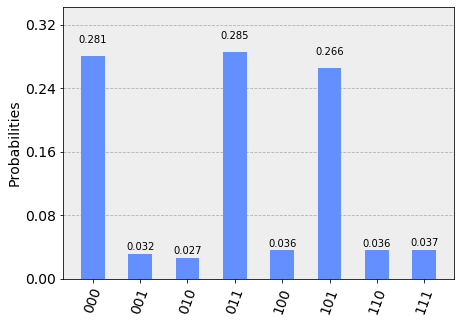

In [5]:
from qiskit.aqua.algorithms import Grover
from qiskit.aqua.components.oracles import LogicalExpressionOracle

# Implementing oracle from example at https://community.qiskit.org/textbook/ch-applications/satisfiability-grover.html
input_3sat = "(~x0|~x1|~x2) & (x0|~x1|x2) & (x0|x1|~x2) & (x0|~x1|~x2) & (~x0|x1|x2)"
oracle = LogicalExpressionOracle(input_3sat)
grover = Grover(oracle)

plot_histogram(grover.run(simulator, shots=1000)["measurement"])

The results are very close given the probabalistic nature of the problem and likely differences in circuit design.